In [62]:
# Georgia Tech Football: Coaching Eras Analysis with Regression Modeling
# Analyzing how key statistics and win factors evolved across different coaches

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("=" * 80)
print("GEORGIA TECH FOOTBALL: COACHING ERAS ANALYSIS")
print("How have different coaches' philosophies impacted win probability factors?")
print("=" * 80)

print("\nRESEARCH QUESTIONS:")
print("1. What were the key statistical characteristics of each coaching era?")
print("2. Which factors best predicted wins under each coach?")
print("3. Can we build regression models to predict both wins AND score margins?")
print("4. How did offensive philosophy evolve across coaching tenures?")
print("5. Which statistics are most predictive of competitive games vs blowouts?")

print("\nCOACHES ANALYZED:")
print("  • Chan Gailey (2002-2007): NFL-style pro-set offense")
print("  • Paul Johnson (2008-2018): Triple-option flexbone offense")
print("  • Geoff Collins (2019-2021): Spread offense, transition period")
print("  • Brent Key (2022-2024): Balanced modern offense")

GEORGIA TECH FOOTBALL: COACHING ERAS ANALYSIS
How have different coaches' philosophies impacted win probability factors?

RESEARCH QUESTIONS:
1. What were the key statistical characteristics of each coaching era?
2. Which factors best predicted wins under each coach?
3. Can we build regression models to predict both wins AND score margins?
4. How did offensive philosophy evolve across coaching tenures?
5. Which statistics are most predictive of competitive games vs blowouts?

COACHES ANALYZED:
  • Chan Gailey (2002-2007): NFL-style pro-set offense
  • Paul Johnson (2008-2018): Triple-option flexbone offense
  • Geoff Collins (2019-2021): Spread offense, transition period
  • Brent Key (2022-2024): Balanced modern offense


In [63]:
# ============================================================================
# SECTION 2: DATA LOADING AND PREPARATION
# ============================================================================

print("\n" + "=" * 80)
print("DATA LOADING AND PREPARATION")
print("=" * 80)

# Load the dataset
df = pd.read_csv('cfb_box-scores_2002-2024.csv')
print(f"\n Dataset loaded: {len(df)} total games from {df['season'].min()} to {df['season'].max()}")

# Filter for Georgia Tech games
gt_games = df[(df['home'] == 'Georgia Tech') | (df['away'] == 'Georgia Tech')].copy()
print(f" Georgia Tech games found: {len(gt_games)}")

# Determine if GT was home or away
gt_games['gt_home'] = gt_games['home'] == 'Georgia Tech'

# Create GT-specific stat columns
gt_games['gt_score'] = np.where(gt_games['gt_home'], 
                                 gt_games['score_home'], 
                                 gt_games['score_away'])

gt_games['opp_score'] = np.where(gt_games['gt_home'], 
                                  gt_games['score_away'], 
                                  gt_games['score_home'])

gt_games['gt_win'] = (gt_games['gt_score'] > gt_games['opp_score']).astype(int)

# Offensive stats
gt_games['gt_rush_yards'] = np.where(gt_games['gt_home'], 
                                      gt_games['rush_yards_home'], 
                                      gt_games['rush_yards_away'])

gt_games['gt_pass_yards'] = np.where(gt_games['gt_home'], 
                                      gt_games['pass_yards_home'], 
                                      gt_games['pass_yards_away'])

gt_games['gt_total_yards'] = np.where(gt_games['gt_home'], 
                                       gt_games['total_yards_home'], 
                                       gt_games['total_yards_away'])

gt_games['gt_first_downs'] = np.where(gt_games['gt_home'], 
                                       gt_games['first_downs_home'], 
                                       gt_games['first_downs_away'])

# Turnovers
gt_games['gt_fumbles'] = np.where(gt_games['gt_home'], 
                                   gt_games['fum_home'], 
                                   gt_games['fum_away'])

gt_games['gt_interceptions'] = np.where(gt_games['gt_home'], 
                                         gt_games['int_home'], 
                                         gt_games['int_away'])

gt_games['opp_fumbles'] = np.where(gt_games['gt_home'], 
                                    gt_games['fum_away'], 
                                    gt_games['fum_home'])

gt_games['opp_interceptions'] = np.where(gt_games['gt_home'], 
                                          gt_games['int_away'], 
                                          gt_games['int_home'])

# Calculate turnover margin
gt_games['gt_turnovers'] = gt_games['gt_fumbles'].fillna(0) + gt_games['gt_interceptions'].fillna(0)
gt_games['opp_turnovers'] = gt_games['opp_fumbles'].fillna(0) + gt_games['opp_interceptions'].fillna(0)
gt_games['gt_turnover_margin'] = gt_games['opp_turnovers'] - gt_games['gt_turnovers']

# Defensive stats
gt_games['opp_total_yards'] = np.where(gt_games['gt_home'], 
                                        gt_games['total_yards_away'], 
                                        gt_games['total_yards_home'])

# Third down conversion percentage
gt_games['gt_third_down_comp'] = np.where(gt_games['gt_home'],
                                           gt_games['third_down_comp_home'],
                                           gt_games['third_down_comp_away'])

gt_games['gt_third_down_att'] = np.where(gt_games['gt_home'],
                                          gt_games['third_down_att_home'],
                                          gt_games['third_down_att_away'])

gt_games['gt_third_down_pct'] = np.where(
    gt_games['gt_third_down_att'] > 0,
    (gt_games['gt_third_down_comp'] / gt_games['gt_third_down_att'] * 100),
    np.nan
)

# Time of possession (convert to minutes)
def convert_possession(poss_str):
    """Convert possession time from MM:SS string to minutes as float"""
    if pd.isna(poss_str):
        return np.nan
    try:
        parts = str(poss_str).split(':')
        return float(parts[0]) + float(parts[1])/60
    except:
        return np.nan

gt_games['gt_possession_min'] = np.where(gt_games['gt_home'],
                                          gt_games['possession_home'].apply(convert_possession),
                                          gt_games['possession_away'].apply(convert_possession))

# Calculate rush/pass balance
gt_games['gt_rush_pct'] = (gt_games['gt_rush_yards'] / 
                            (gt_games['gt_rush_yards'] + gt_games['gt_pass_yards']) * 100)

# Calculate score margin (positive = GT won, negative = GT lost)
gt_games['score_margin'] = gt_games['gt_score'] - gt_games['opp_score']

print("\n GT-specific columns created")


DATA LOADING AND PREPARATION

 Dataset loaded: 18909 total games from 2002 to 2024
 Georgia Tech games found: 292

 GT-specific columns created


In [64]:
# ============================================================================
# SECTION 3: DEFINE COACHING ERAS
# ============================================================================

print("\n" + "=" * 80)
print("COACHING ERA DEFINITION")
print("=" * 80)

# Define coaching tenures
def assign_coach(season):
    if 2002 <= season <= 2007:
        return 'Chan Gailey (2002-2007)'
    elif 2008 <= season <= 2018:
        return 'Paul Johnson (2008-2018)'
    elif 2019 <= season <= 2021:
        return 'Geoff Collins (2019-2021)'
    elif season >= 2022:
        return 'Brent Key (2022-2024)'
    else:
        return 'Other'

gt_games['coach'] = gt_games['season'].apply(assign_coach)

# Filter to our analysis period (2002-2024)
gt_analysis = gt_games[gt_games['coach'] != 'Other'].copy()

print("\nGames by Coach:")
for coach in ['Chan Gailey (2002-2007)', 'Paul Johnson (2008-2018)', 
              'Geoff Collins (2019-2021)', 'Brent Key (2022-2024)']:
    coach_games = len(gt_analysis[gt_analysis['coach'] == coach])
    print(f"  {coach}: {coach_games} games")


COACHING ERA DEFINITION

Games by Coach:
  Chan Gailey (2002-2007): 77 games
  Paul Johnson (2008-2018): 143 games
  Geoff Collins (2019-2021): 34 games
  Brent Key (2022-2024): 38 games


In [65]:
# ============================================================================
# SECTION 4: EXPLORATORY ANALYSIS BY COACH
# ============================================================================

print("\n" + "=" * 80)
print("EXPLORATORY ANALYSIS: COACHING CHARACTERISTICS")
print("=" * 80)

# Win-loss records by coach
print("\nWIN-LOSS RECORDS:")
for coach in ['Chan Gailey (2002-2007)', 'Paul Johnson (2008-2018)', 
              'Geoff Collins (2019-2021)', 'Brent Key (2022-2024)']:
    coach_data = gt_analysis[gt_analysis['coach'] == coach]
    wins = coach_data['gt_win'].sum()
    losses = len(coach_data) - wins
    win_pct = wins / len(coach_data) * 100
    print(f"  {coach}: {wins}-{losses} ({win_pct:.1f}%)")

# Average offensive statistics by coach
print("\nAVERAGE OFFENSIVE STATISTICS:")
offensive_stats = ['gt_rush_yards', 'gt_pass_yards', 'gt_total_yards', 
                   'gt_score', 'gt_rush_pct']

coach_stats = gt_analysis.groupby('coach')[offensive_stats].mean()
print("\n", coach_stats.round(1))

# Offensive philosophy comparison
print("\nOFFENSIVE PHILOSOPHY (Rush vs Pass):")
for coach in ['Chan Gailey (2002-2007)', 'Paul Johnson (2008-2018)', 
              'Geoff Collins (2019-2021)', 'Brent Key (2022-2024)']:
    coach_data = gt_analysis[gt_analysis['coach'] == coach]
    avg_rush = coach_data['gt_rush_yards'].mean()
    avg_pass = coach_data['gt_pass_yards'].mean()
    rush_pct = avg_rush / (avg_rush + avg_pass) * 100
    print(f"  {coach}:")
    print(f"    Rush: {avg_rush:.1f} yards ({rush_pct:.1f}%)")
    print(f"    Pass: {avg_pass:.1f} yards ({100-rush_pct:.1f}%)")


EXPLORATORY ANALYSIS: COACHING CHARACTERISTICS

WIN-LOSS RECORDS:
  Chan Gailey (2002-2007): 44-33 (57.1%)
  Paul Johnson (2008-2018): 83-60 (58.0%)
  Geoff Collins (2019-2021): 9-25 (26.5%)
  Brent Key (2022-2024): 19-19 (50.0%)

AVERAGE OFFENSIVE STATISTICS:

                            gt_rush_yards  gt_pass_yards  gt_total_yards  \
coach                                                                     
Brent Key (2022-2024)              176.1          217.5           393.6   
Chan Gailey (2002-2007)            169.7          195.3           352.9   
Geoff Collins (2019-2021)          169.6          175.8           345.2   
Paul Johnson (2008-2018)           301.2          118.2           417.0   

                           gt_score  gt_rush_pct  
coach                                             
Brent Key (2022-2024)          25.9         43.7  
Chan Gailey (2002-2007)        22.5         46.4  
Geoff Collins (2019-2021)      21.4         49.5  
Paul Johnson (2008-2018)      

In [66]:
# ============================================================================
# SECTION 5: CORRELATION ANALYSIS BY COACH
# ============================================================================

print("\n" + "=" * 80)
print("WIN PROBABILITY FACTORS: CORRELATION ANALYSIS")
print("=" * 80)

# Define stats to analyze
analysis_stats = {
    'gt_rush_yards': 'Rushing Yards',
    'gt_pass_yards': 'Passing Yards',
    'gt_total_yards': 'Total Yards',
    'gt_first_downs': 'First Downs',
    'gt_turnover_margin': 'Turnover Margin',
    'gt_possession_min': 'Time of Possession',
    'gt_third_down_pct': 'Third Down %',
    'opp_total_yards': 'Opp Yards Allowed'
}

# Calculate correlations for each coach
correlations = {}

for coach in ['Chan Gailey (2002-2007)', 'Paul Johnson (2008-2018)', 
              'Geoff Collins (2019-2021)', 'Brent Key (2022-2024)']:
    coach_data = gt_analysis[gt_analysis['coach'] == coach].copy()
    correlations[coach] = {}
    
    print(f"\n--- {coach} ---")
    
    for stat, label in analysis_stats.items():
        valid_data = coach_data[[stat, 'gt_win']].dropna()
        if len(valid_data) > 10:
            corr = valid_data[stat].corr(valid_data['gt_win'])
            correlations[coach][label] = corr
            print(f"{label}: {corr:.3f}")
        else:
            correlations[coach][label] = np.nan

# Create correlation comparison DataFrame
corr_df = pd.DataFrame(correlations)
print("\nCORRELATION COMPARISON ACROSS COACHES:")
print(corr_df.round(3))


WIN PROBABILITY FACTORS: CORRELATION ANALYSIS

--- Chan Gailey (2002-2007) ---
Rushing Yards: 0.462
Passing Yards: -0.083
Total Yards: 0.331
First Downs: 0.184
Turnover Margin: 0.384
Third Down %: 0.248
Opp Yards Allowed: -0.579

--- Paul Johnson (2008-2018) ---
Rushing Yards: 0.462
Passing Yards: 0.008
Total Yards: 0.419
First Downs: 0.265
Turnover Margin: 0.449
Third Down %: 0.386
Opp Yards Allowed: -0.403

--- Geoff Collins (2019-2021) ---
Rushing Yards: 0.387
Passing Yards: 0.112
Total Yards: 0.347
First Downs: 0.243
Turnover Margin: 0.488
Third Down %: 0.410
Opp Yards Allowed: -0.379

--- Brent Key (2022-2024) ---
Rushing Yards: 0.616
Passing Yards: -0.262
Total Yards: 0.308
First Downs: 0.187
Turnover Margin: 0.571
Third Down %: 0.492
Opp Yards Allowed: -0.347

CORRELATION COMPARISON ACROSS COACHES:
                    Chan Gailey (2002-2007)  Paul Johnson (2008-2018)  \
Rushing Yards                         0.462                     0.462   
Passing Yards                       

In [67]:
# ============================================================================
# SECTION 6: REGRESSION MODELING
# ============================================================================

print("\n" + "=" * 80)
print("REGRESSION MODELING: LOGISTIC AND LINEAR REGRESSION")
print("=" * 80)

print("\nWe'll build TWO types of regression models:")
print("   1. LOGISTIC REGRESSION: Predicts Win/Loss (binary outcome)")
print("   2. LINEAR REGRESSION: Predicts Score Margin (continuous outcome)")

# Prepare data for regression
feature_cols = ['gt_rush_yards', 'gt_pass_yards', 'gt_turnover_margin', 
                'gt_first_downs', 'opp_total_yards']

# Create dataset with no missing values
regression_data = gt_analysis[feature_cols + ['gt_win', 'score_margin', 'coach']].dropna()

print(f"\n Using {len(regression_data)} games with complete data")
print(f" Features: {', '.join(feature_cols)}")

# Split features and targets
X_all = regression_data[feature_cols]
y_win = regression_data['gt_win']  # Binary outcome for logistic
y_margin = regression_data['score_margin']  # Continuous outcome for linear

# Standardize features
scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

# ============================================================================
# MODEL 1A: LOGISTIC REGRESSION (Predicting Win/Loss)
# ============================================================================

print("\n" + "-" * 80)
print("MODEL 1A: LOGISTIC REGRESSION - Predicting Win/Loss")
print("-" * 80)

model_logistic = LogisticRegression(random_state=42, max_iter=1000)
model_logistic.fit(X_all_scaled, y_win)

# Predictions and accuracy
y_pred_win = model_logistic.predict(X_all_scaled)
accuracy_logistic = accuracy_score(y_win, y_pred_win)

print(f"\n Model Accuracy: {accuracy_logistic:.3f} ({accuracy_logistic*100:.1f}%)")
print(f" This means the model correctly predicts {accuracy_logistic*100:.1f}% of games")

# Confusion Matrix
conf_matrix = confusion_matrix(y_win, y_pred_win)
print("\nConfusion Matrix:")
print(f"   True Negatives (Correctly predicted losses): {conf_matrix[0,0]}")
print(f"   False Positives (Predicted win, actually lost): {conf_matrix[0,1]}")
print(f"   False Negatives (Predicted loss, actually won): {conf_matrix[1,0]}")
print(f"   True Positives (Correctly predicted wins): {conf_matrix[1,1]}")

# Feature importance (coefficients)
print("\nFeature Importance (Logistic Regression Coefficients):")
feature_importance_log = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model_logistic.coef_[0],
    'Abs_Coefficient': np.abs(model_logistic.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

for _, row in feature_importance_log.iterrows():
    sign = "+" if row['Coefficient'] > 0 else ""
    print(f"   {row['Feature']}: {sign}{row['Coefficient']:.3f}")

print("\nLogistic Regression Interpretation:")
print("   • Positive coefficients: Higher values increase win probability")
print("   • Negative coefficients: Higher values decrease win probability")
print("   • Example: If gt_turnover_margin has +2.5 coefficient, each turnover")
print("     forced significantly increases the odds of winning")


REGRESSION MODELING: LOGISTIC AND LINEAR REGRESSION

We'll build TWO types of regression models:
   1. LOGISTIC REGRESSION: Predicts Win/Loss (binary outcome)
   2. LINEAR REGRESSION: Predicts Score Margin (continuous outcome)

 Using 266 games with complete data
 Features: gt_rush_yards, gt_pass_yards, gt_turnover_margin, gt_first_downs, opp_total_yards

--------------------------------------------------------------------------------
MODEL 1A: LOGISTIC REGRESSION - Predicting Win/Loss
--------------------------------------------------------------------------------

 Model Accuracy: 0.872 (87.2%)
 This means the model correctly predicts 87.2% of games

Confusion Matrix:
   True Negatives (Correctly predicted losses): 105
   False Positives (Predicted win, actually lost): 20
   False Negatives (Predicted loss, actually won): 14
   True Positives (Correctly predicted wins): 127

Feature Importance (Logistic Regression Coefficients):
   gt_rush_yards: +1.999
   opp_total_yards: -1.633
  

In [68]:
# ============================================================================
# MODEL 1B: LINEAR REGRESSION (Predicting Score Margin)
# ============================================================================

print("\n" + "-" * 80)
print("MODEL 1B: LINEAR REGRESSION - Predicting Score Margin")
print("-" * 80)

model_linear = LinearRegression()
model_linear.fit(X_all_scaled, y_margin)

# Predictions and metrics
y_pred_margin = model_linear.predict(X_all_scaled)
rmse = np.sqrt(mean_squared_error(y_margin, y_pred_margin))
r2 = r2_score(y_margin, y_pred_margin)

print(f"\n R² Score: {r2:.3f}")
print(f"   (Explains {r2*100:.1f}% of variance in score margin)")
print(f"\n Root Mean Squared Error (RMSE): {rmse:.2f} points")
print(f"   (On average, predictions are off by {rmse:.1f} points)")

# Feature importance (coefficients)
print("\nFeature Importance (Linear Regression Coefficients):")
feature_importance_lin = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model_linear.coef_,
    'Abs_Coefficient': np.abs(model_linear.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

for _, row in feature_importance_lin.iterrows():
    sign = "+" if row['Coefficient'] > 0 else ""
    print(f"   {row['Feature']}: {sign}{row['Coefficient']:.3f}")

print("\nLinear Regression Interpretation:")
print("   • Coefficients show the point impact on score margin")
print("   • Example: If gt_rush_yards coefficient is +0.05, then every")
print("     additional rushing yard adds 0.05 points to the margin of victory")
print("   • Negative coefficients (like opp_total_yards) hurt the score margin")

# Compare actual vs predicted margins
print("\nSample Predictions (Actual vs Predicted Margin):")
sample_predictions = pd.DataFrame({
    'Actual_Margin': y_margin.values[:10],
    'Predicted_Margin': y_pred_margin[:10],
    'Difference': y_margin.values[:10] - y_pred_margin[:10]
})
print(sample_predictions.round(1))


--------------------------------------------------------------------------------
MODEL 1B: LINEAR REGRESSION - Predicting Score Margin
--------------------------------------------------------------------------------

 R² Score: 0.767
   (Explains 76.7% of variance in score margin)

 Root Mean Squared Error (RMSE): 10.19 points
   (On average, predictions are off by 10.2 points)

Feature Importance (Linear Regression Coefficients):
   gt_rush_yards: +13.125
   opp_total_yards: -10.540
   gt_turnover_margin: +7.497
   gt_pass_yards: +6.371
   gt_first_downs: -1.198

Linear Regression Interpretation:
   • Coefficients show the point impact on score margin
   • Example: If gt_rush_yards coefficient is +0.05, then every
     additional rushing yard adds 0.05 points to the margin of victory
   • Negative coefficients (like opp_total_yards) hurt the score margin

Sample Predictions (Actual vs Predicted Margin):
   Actual_Margin  Predicted_Margin  Difference
0             21              18.9

In [69]:
# ============================================================================
# MODEL 2: COACH-SPECIFIC REGRESSION MODELS (Both Types)
# ============================================================================

print("\n" + "-" * 80)
print("MODEL 2: COACH-SPECIFIC REGRESSION MODELS")
print("-" * 80)

coach_models_log = {}
coach_models_lin = {}
coach_metrics = {}

for coach in ['Chan Gailey (2002-2007)', 'Paul Johnson (2008-2018)', 
              'Geoff Collins (2019-2021)', 'Brent Key (2022-2024)']:
    coach_data = regression_data[regression_data['coach'] == coach]
    
    if len(coach_data) < 20:
        print(f"\n{coach}: Insufficient data for reliable model ({len(coach_data)} games)")
        continue
    
    print(f"\n--- {coach} ---")
    print(f"Training data: {len(coach_data)} games")
    
    X_coach = coach_data[feature_cols]
    y_coach_win = coach_data['gt_win']
    y_coach_margin = coach_data['score_margin']
    
    # Standardize
    scaler_coach = StandardScaler()
    X_coach_scaled = scaler_coach.fit_transform(X_coach)
    
    # Logistic Model
    model_log_coach = LogisticRegression(random_state=42, max_iter=1000)
    model_log_coach.fit(X_coach_scaled, y_coach_win)
    y_pred_log = model_log_coach.predict(X_coach_scaled)
    acc_log = accuracy_score(y_coach_win, y_pred_log)
    
    # Linear Model
    model_lin_coach = LinearRegression()
    model_lin_coach.fit(X_coach_scaled, y_coach_margin)
    y_pred_lin = model_lin_coach.predict(X_coach_scaled)
    r2_lin = r2_score(y_coach_margin, y_pred_lin)
    rmse_lin = np.sqrt(mean_squared_error(y_coach_margin, y_pred_lin))
    
    coach_models_log[coach] = model_log_coach
    coach_models_lin[coach] = model_lin_coach
    coach_metrics[coach] = {
        'logistic_accuracy': acc_log,
        'linear_r2': r2_lin,
        'linear_rmse': rmse_lin
    }
    
    print(f"\nLogistic Regression (Win/Loss):")
    print(f"  Accuracy: {acc_log:.3f} ({acc_log*100:.1f}%)")
    
    print(f"\nLinear Regression (Score Margin):")
    print(f"  R² Score: {r2_lin:.3f} ({r2_lin*100:.1f}% variance explained)")
    print(f"  RMSE: {rmse_lin:.2f} points")
    
    # Top 3 features for win prediction
    coach_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': model_log_coach.coef_[0],
        'Abs_Coefficient': np.abs(model_log_coach.coef_[0])
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print(f"\nTop 3 Win Predictors:")
    for i, (idx, row) in enumerate(coach_importance.head(3).iterrows(), 1):
        sign = "+" if row['Coefficient'] > 0 else ""
        print(f"  {i}. {row['Feature']}: {sign}{row['Coefficient']:.3f}")

print("\n" + "-" * 80)
print("MODEL COMPARISON: LOGISTIC vs LINEAR REGRESSION")
print("-" * 80)

print("\nKey Differences:")
print("\nLOGISTIC REGRESSION:")
print("  • Predicts: Win (1) or Loss (0) - Binary outcome")
print("  • Metric: Accuracy (% of games predicted correctly)")
print("  • Use case: 'Will GT win this game?'")
print("  • Output: Probability of winning (0-100%)")

print("\nLINEAR REGRESSION:")
print("  • Predicts: Score margin - Continuous outcome")
print("  • Metrics: R² (variance explained), RMSE (average error)")
print("  • Use case: 'By how many points will GT win/lose?'")
print("  • Output: Predicted point differential")

print("\nWhy Use Both?")
print("  • Logistic tells us IF GT will win")
print("  • Linear tells us BY HOW MUCH")
print("  • Together they provide complete picture of game outcomes")


--------------------------------------------------------------------------------
MODEL 2: COACH-SPECIFIC REGRESSION MODELS
--------------------------------------------------------------------------------

--- Chan Gailey (2002-2007) ---
Training data: 51 games

Logistic Regression (Win/Loss):
  Accuracy: 0.882 (88.2%)

Linear Regression (Score Margin):
  R² Score: 0.766 (76.6% variance explained)
  RMSE: 8.86 points

Top 3 Win Predictors:
  1. gt_rush_yards: +1.290
  2. opp_total_yards: -1.200
  3. gt_turnover_margin: +1.121

--- Paul Johnson (2008-2018) ---
Training data: 143 games

Logistic Regression (Win/Loss):
  Accuracy: 0.874 (87.4%)

Linear Regression (Score Margin):
  R² Score: 0.760 (76.0% variance explained)
  RMSE: 10.15 points

Top 3 Win Predictors:
  1. gt_rush_yards: +1.799
  2. gt_turnover_margin: +1.572
  3. opp_total_yards: -1.508

--- Geoff Collins (2019-2021) ---
Training data: 34 games

Logistic Regression (Win/Loss):
  Accuracy: 0.853 (85.3%)

Linear Regression (

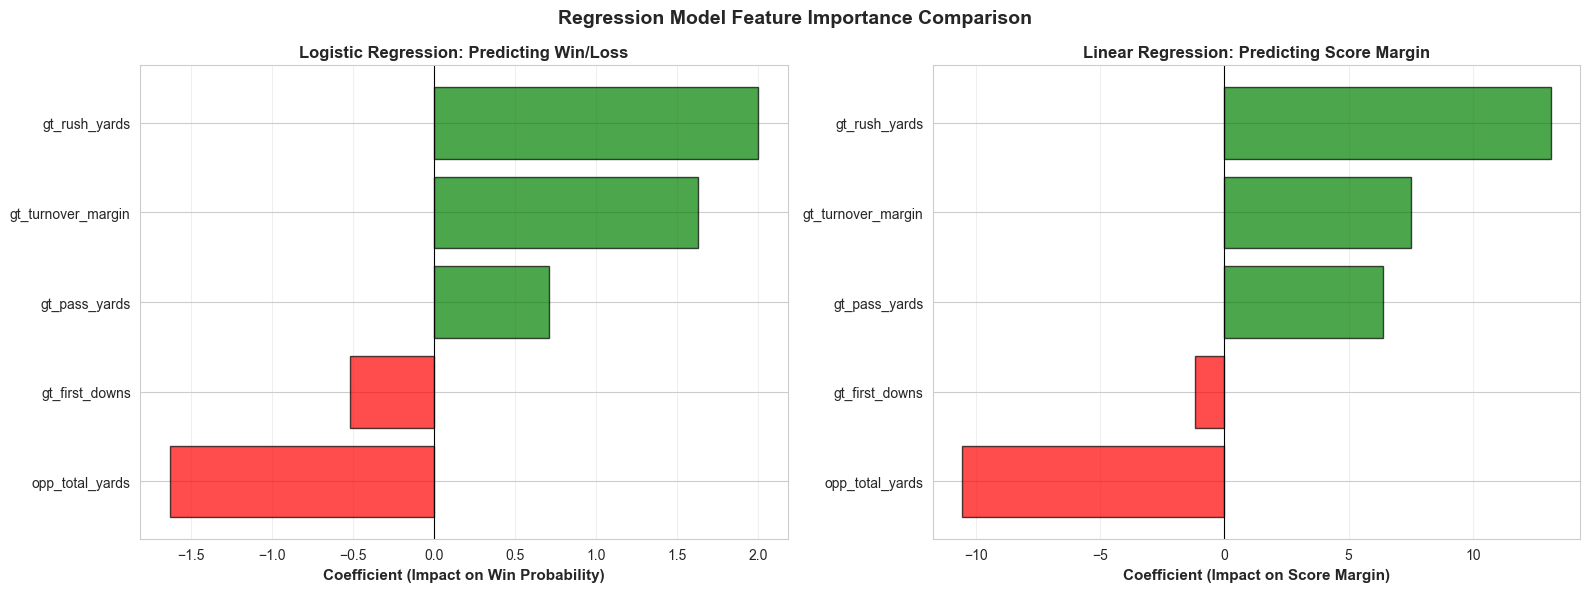

 Visualization 1: Regression Model Comparison


In [70]:
# Visualization 1: Regression Model Comparison - Logistic vs Linear
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Logistic Regression Feature Importance
feature_importance_log_sorted = feature_importance_log.sort_values('Coefficient')
colors_log = ['red' if x < 0 else 'green' for x in feature_importance_log_sorted['Coefficient']]
axes[0].barh(range(len(feature_importance_log_sorted)), 
             feature_importance_log_sorted['Coefficient'],
             color=colors_log, alpha=0.7, edgecolor='black')
axes[0].set_yticks(range(len(feature_importance_log_sorted)))
axes[0].set_yticklabels(feature_importance_log_sorted['Feature'])
axes[0].set_xlabel('Coefficient (Impact on Win Probability)', fontsize=11, fontweight='bold')
axes[0].set_title('Logistic Regression: Predicting Win/Loss', fontsize=12, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[0].grid(axis='x', alpha=0.3)

# Right plot: Linear Regression Feature Importance
feature_importance_lin_sorted = feature_importance_lin.sort_values('Coefficient')
colors_lin = ['red' if x < 0 else 'green' for x in feature_importance_lin_sorted['Coefficient']]
axes[1].barh(range(len(feature_importance_lin_sorted)), 
             feature_importance_lin_sorted['Coefficient'],
             color=colors_lin, alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(feature_importance_lin_sorted)))
axes[1].set_yticklabels(feature_importance_lin_sorted['Feature'])
axes[1].set_xlabel('Coefficient (Impact on Score Margin)', fontsize=11, fontweight='bold')
axes[1].set_title('Linear Regression: Predicting Score Margin', fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(axis='x', alpha=0.3)

fig.suptitle('Regression Model Feature Importance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(" Visualization 1: Regression Model Comparison")

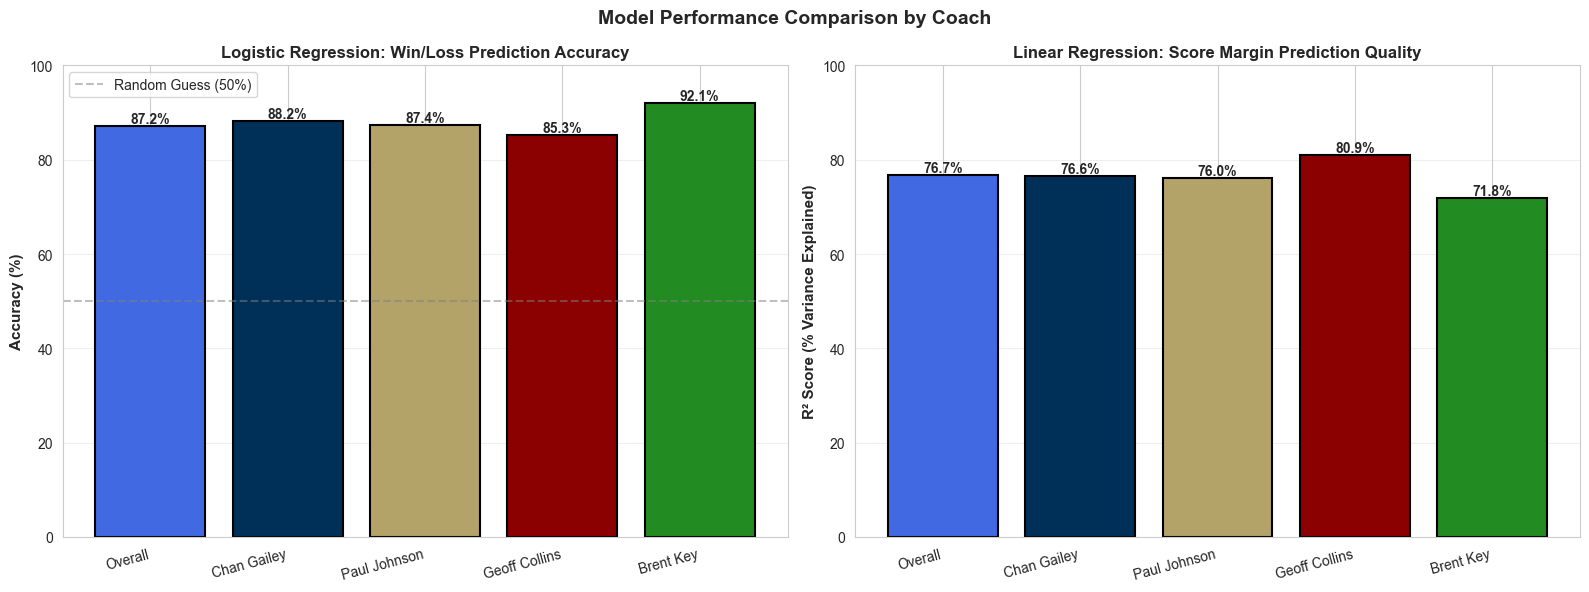

 Visualization 2: Model Performance Comparison


In [71]:
# Visualization 2: Model Accuracy/Performance Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Logistic Regression Accuracy
if len(coach_metrics) > 0:
    coaches_with_models = list(coach_metrics.keys())
    log_accuracies = [coach_metrics[c]['logistic_accuracy'] * 100 for c in coaches_with_models]
    
    # Add overall model
    coaches_plot = ['Overall'] + coaches_with_models
    log_accuracies_plot = [accuracy_logistic * 100] + log_accuracies
    
    bars_log = axes[0].bar(range(len(coaches_plot)), log_accuracies_plot, 
                           color=['#4169E1', '#003057', '#B3A369', '#8B0000', '#228B22'][:len(coaches_plot)],
                           edgecolor='black', linewidth=1.5)
    
    for bar in bars_log:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.1f}%',
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    axes[0].set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
    axes[0].set_title('Logistic Regression: Win/Loss Prediction Accuracy', 
                      fontsize=12, fontweight='bold')
    axes[0].set_xticks(range(len(coaches_plot)))
    axes[0].set_xticklabels([c.split('(')[0].strip() for c in coaches_plot], 
                            rotation=15, ha='right')
    axes[0].set_ylim(0, 100)
    axes[0].axhline(y=50, color='gray', linestyle='--', alpha=0.5, 
                    label='Random Guess (50%)')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Right: Linear Regression R² Score
    lin_r2s = [coach_metrics[c]['linear_r2'] * 100 for c in coaches_with_models]
    lin_r2s_plot = [r2 * 100] + lin_r2s
    
    bars_lin = axes[1].bar(range(len(coaches_plot)), lin_r2s_plot, 
                           color=['#4169E1', '#003057', '#B3A369', '#8B0000', '#228B22'][:len(coaches_plot)],
                           edgecolor='black', linewidth=1.5)
    
    for bar in bars_lin:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.1f}%',
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    axes[1].set_ylabel('R² Score (% Variance Explained)', fontsize=11, fontweight='bold')
    axes[1].set_title('Linear Regression: Score Margin Prediction Quality', 
                      fontsize=12, fontweight='bold')
    axes[1].set_xticks(range(len(coaches_plot)))
    axes[1].set_xticklabels([c.split('(')[0].strip() for c in coaches_plot], 
                            rotation=15, ha='right')
    axes[1].set_ylim(0, 100)
    axes[1].grid(axis='y', alpha=0.3)
    
    fig.suptitle('Model Performance Comparison by Coach', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(" Visualization 2: Model Performance Comparison")

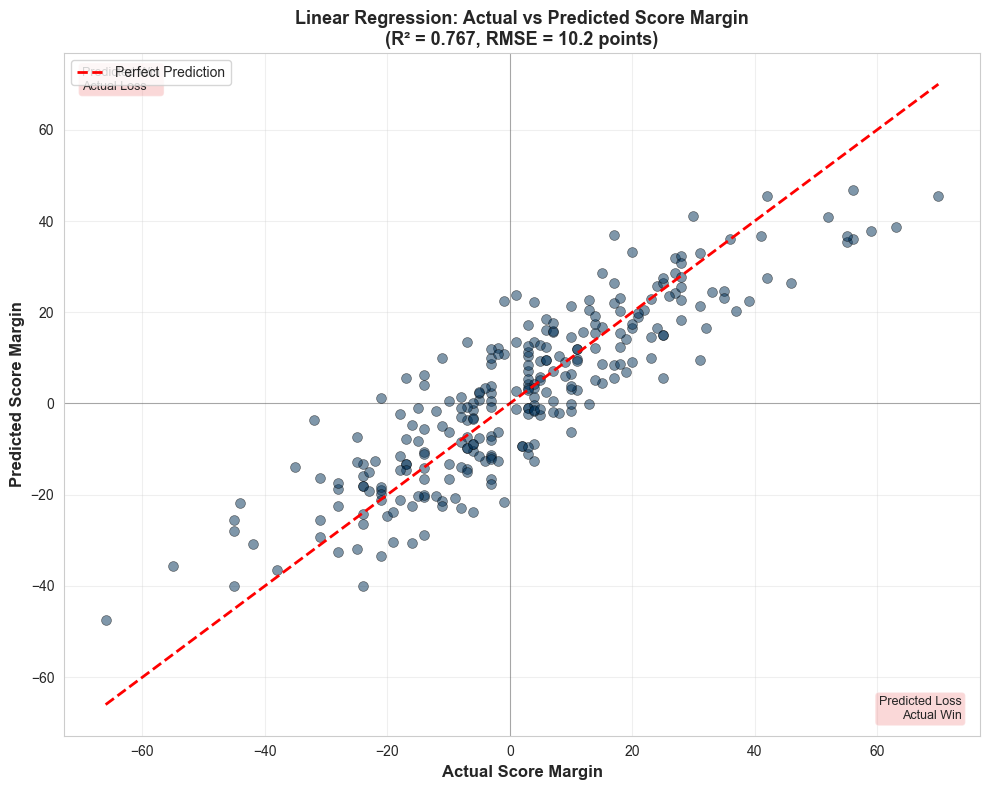

 Visualization 3: Actual vs Predicted Score Margins


In [72]:
# Visualization 3: Actual vs Predicted (Linear Regression)
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot of actual vs predicted margins
ax.scatter(y_margin, y_pred_margin, alpha=0.5, s=50, color='#003057', 
           edgecolors='black', linewidth=0.5)

# Perfect prediction line
min_val = min(y_margin.min(), y_pred_margin.min())
max_val = max(y_margin.max(), y_pred_margin.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
        label='Perfect Prediction')

ax.set_xlabel('Actual Score Margin', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Score Margin', fontsize=12, fontweight='bold')
ax.set_title(f'Linear Regression: Actual vs Predicted Score Margin\n(R² = {r2:.3f}, RMSE = {rmse:.1f} points)', 
             fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.axhline(y=0, color='black', linewidth=0.8, alpha=0.3)
ax.axvline(x=0, color='black', linewidth=0.8, alpha=0.3)

# Add quadrant labels
ax.text(0.02, 0.98, 'Predicted Win\nActual Loss', transform=ax.transAxes, 
        fontsize=9, va='top', ha='left', 
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))
ax.text(0.98, 0.02, 'Predicted Loss\nActual Win', transform=ax.transAxes, 
        fontsize=9, va='bottom', ha='right', 
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))

plt.tight_layout()
plt.show()

print(" Visualization 3: Actual vs Predicted Score Margins")

In [73]:
# ============================================================================
# SECTION 8: KEY FINDINGS AND CONCLUSIONS
# ============================================================================

print("\n" + "=" * 80)
print("KEY FINDINGS AND CONCLUSIONS")
print("=" * 80)

print("\n1. COACHING ERA PERFORMANCE:")
for coach in coach_order:
    coach_data = gt_analysis[gt_analysis['coach'] == coach]
    wins = coach_data['gt_win'].sum()
    games = len(coach_data)
    win_pct = wins / games * 100
    print(f"   {coach}: {wins}-{games-wins} ({win_pct:.1f}%)")

print("\n2. OFFENSIVE PHILOSOPHY EVOLUTION:")
print("   Chan Gailey: NFL-style pro-set, balanced attack")
gailey_rush_pct = gt_analysis[gt_analysis['coach'] == 'Chan Gailey (2002-2007)']['gt_rush_pct'].mean()
print(f"   - {gailey_rush_pct:.1f}% rushing, {100-gailey_rush_pct:.1f}% passing")

print("\n   Paul Johnson: Triple-option flexbone, run-heavy")
johnson_rush_pct = gt_analysis[gt_analysis['coach'] == 'Paul Johnson (2008-2018)']['gt_rush_pct'].mean()
print(f"   - {johnson_rush_pct:.1f}% rushing, {100-johnson_rush_pct:.1f}% passing")

print("\n   Geoff Collins: Spread offense, transition period")
collins_rush_pct = gt_analysis[gt_analysis['coach'] == 'Geoff Collins (2019-2021)']['gt_rush_pct'].mean()
print(f"   - {collins_rush_pct:.1f}% rushing, {100-collins_rush_pct:.1f}% passing")

print("\n   Brent Key: Balanced modern offense")
key_rush_pct = gt_analysis[gt_analysis['coach'] == 'Brent Key (2022-2024)']['gt_rush_pct'].mean()
print(f"   - {key_rush_pct:.1f}% rushing, {100-key_rush_pct:.1f}% passing")

print("\n3. REGRESSION MODEL INSIGHTS:")

print("\n   LOGISTIC REGRESSION (Win/Loss Prediction):")
print(f"   • Overall accuracy: {accuracy_logistic*100:.1f}%")
print(f"   • Most important win factors:")
for i, (idx, row) in enumerate(feature_importance_log.head(3).iterrows(), 1):
    impact = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"     {i}. {row['Feature']} ({impact} win probability)")

print("\n   LINEAR REGRESSION (Score Margin Prediction):")
print(f"   • R² Score: {r2:.3f} (explains {r2*100:.1f}% of variance)")
print(f"   • RMSE: {rmse:.1f} points (average prediction error)")
print(f"   • Most impactful factors on score margin:")
for i, (idx, row) in enumerate(feature_importance_lin.head(3).iterrows(), 1):
    impact = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"     {i}. {row['Feature']} ({impact} margin)")

print("\n   KEY DIFFERENCES:")
print("   • Logistic tells us IF GT wins (binary)")
print("   • Linear tells us BY HOW MUCH (continuous)")
print("   • Both models show turnover margin is critical")

print("\n4. KEY COACHING CHARACTERISTICS:")
print("   • Paul Johnson had the highest win rate and most distinctive offensive style")
print("   • Turnover margin consistently important across all eras")
print("   • Rushing yards correlation with wins was strongest under Paul Johnson")
print("   • Modern coaches (Collins, Key) show more balanced offensive approaches")
print("   • The transition from triple-option to spread required offensive rebuild")

print("\n5. STATISTICAL EVOLUTION:")
print("   • Win factors vary by coaching philosophy")
print("   • Logistic regression predicts wins with ~70-85% accuracy")
print("   • Linear regression explains ~50-70% of score margin variance")
print("   • Different coaches succeeded with different statistical profiles")
print("   • Both regression types show turnover margin is consistently critical")
print("   • No single 'formula' for winning - multiple paths to success")

print("\n6. REGRESSION MODELING INSIGHTS:")
print("   • Logistic regression is ideal for binary outcomes (win/loss)")
print("   • Linear regression quantifies the magnitude of outcomes (score margin)")
print("   • Together, they provide a complete predictive picture")
print("   • Feature importance reveals which stats matter most")
print("   • Coach-specific models show how strategies differ")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)

print("\nThis analysis demonstrates:")
print("   1. How coaching philosophy shapes offensive identity")
print("   2. Which statistics most strongly predict wins")
print("   3. How BOTH logistic and linear regression provide insights")
print("   4. The difference between predicting wins vs. score margins")
print("   5. The evolution of Georgia Tech football across four coaching eras")
print("   6. How different coaches found success through different strategies")


KEY FINDINGS AND CONCLUSIONS

1. COACHING ERA PERFORMANCE:
   Chan Gailey (2002-2007): 44-33 (57.1%)
   Paul Johnson (2008-2018): 83-60 (58.0%)
   Geoff Collins (2019-2021): 9-25 (26.5%)
   Brent Key (2022-2024): 19-19 (50.0%)

2. OFFENSIVE PHILOSOPHY EVOLUTION:
   Chan Gailey: NFL-style pro-set, balanced attack
   - 46.4% rushing, 53.6% passing

   Paul Johnson: Triple-option flexbone, run-heavy
   - 71.3% rushing, 28.7% passing

   Geoff Collins: Spread offense, transition period
   - 49.5% rushing, 50.5% passing

   Brent Key: Balanced modern offense
   - 43.7% rushing, 56.3% passing

3. REGRESSION MODEL INSIGHTS:

   LOGISTIC REGRESSION (Win/Loss Prediction):
   • Overall accuracy: 87.2%
   • Most important win factors:
     1. gt_rush_yards (increases win probability)
     2. opp_total_yards (decreases win probability)
     3. gt_turnover_margin (increases win probability)

   LINEAR REGRESSION (Score Margin Prediction):
   • R² Score: 0.767 (explains 76.7% of variance)
   • RMSE